In [29]:
.libPaths("/home/astromain/R/x86_64-pc-linux-gnu-library/bulk_lib_packages")
.libPaths()

[1] "/home/astromain/R/x86_64-pc-linux-gnu-library/bulk_lib_packages"
[2] "/usr/local/lib/R/site-library"                                  
[3] "/usr/lib/R/site-library"                                        
[4] "/usr/lib/R/library"

In [30]:
library(tidyverse)
library(CCA)
library(tseries)
library(IRdisplay)
library(urca)
library(forecast)
library(vars)
library(xts)
library(gridExtra)
library(ggplot2)
library(tsDyn)

In [31]:
df <- read.csv("../data/Final_Dataset/Predict_Avg_Eggs_Price_Dataset.csv")
print(class(df))
print(dim(df))

for (col in colnames(df)) {print(col)}

[1] "data.frame"
[1] 158  67
[1] "X"
[1] "Gle_Trend_Brid_Flu"
[1] "Wiki_Page_View_Eggs_Substitutes"
[1] "Gle_Trend_Chicken_Feed_Price"
[1] "Gle_Trend_Eggs_Prices"
[1] "Gle_Trend_Eggs_Shortage"
[1] "Wiki_Page_View_Bird_Flu"
[1] "Wiki_Page_View_Price_of_Eggs"
[1] "GDelt_Article_Count_seach_term_food_agri_livestock_infla_commo_supplychain"
[1] "GDelt_Sentiment_seach_term_food_agri_livestock_infla_commo_supplychain"
[1] "Rate_of_Lay_Eggs_100_Layer"
[1] "Chicks_Hatched"
[1] "Corn_Price_Received"
[1] "Average.Price..Malt.Beverages..All.Types..All.Sizes..Any.Origin..Cost.per.16.Ounces.473.2.Milliliters..in.U.S..City.Average"
[1] "Average.Price..Wine..Red.and.White.Table..All.Sizes..Any.Origin..Cost.per.1.Liter.33.8.Ounces..in.U.S..City.Average"
[1] "Average.Price..All.Uncooked.Beef.Roasts..Cost.per.Pound.453.6.Grams..in.U.S..City.Average"
[1] "Average.Price..All.Uncooked.Beef.Steaks..Cost.per.Pound.453.6.Grams..in.U.S..City.Average"
[1] "Average.Price..All.Uncooked.Other.Beef..Excluding.Veal.

In [32]:
df_xts <- xts(df[, !names(df) %in% "X"], order.by = as.Date(df$X))

In [33]:
target_variable <- "Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average"

In [34]:
selected_vars <- c(
                   "Gle_Trend_Eggs_Prices",
                   "Gle_Trend_Eggs_Shortage",
                   "Rate_of_Lay_Eggs_100_Layer",
                   "Chicks_Hatched",
                   "Corn_Price_Received",
                   "Average.Price..Flour..White..All.Purpose..Cost.per.Pound.453.6.Grams..in.U.S..City.Average",
                   "Average.Price..Chicken..Fresh..Whole..Cost.per.Pound.453.6.Grams..in.U.S..City.Average",
                   "Average.Price..Beans..Dried..Any.Type..All.Sizes..Cost.per.Pound.453.6.Grams..in.U.S..City.Average",
                   "Personal.consumption.expenditures..Food"
                   )

\begin{equation}
\Delta Y_t = \Pi Y_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta Y_{t-i} + \epsilon_t
\end{equation}

# Unit Root & I(1) Tests

In [36]:
analyze_variable_old <- function(variable_name, variable_serie, lagmax) {
    # Remove NA values
    variable_serie <- na.omit(variable_serie)

    # Select the most common lag between the one computed with AIC, HQ, SC and FPE methods
    lagselect <- VARselect(variable_serie, lag.max = lagmax, type = "const")
    most_common_lag <- as.numeric(names(sort(table(lagselect$selection), decreasing = TRUE)[1])) - 1

    # Augmented Dickey-Fuller test
    adf_result <- adf.test(variable_serie, k = most_common_lag)
    print(adf_result)
    # We can also compute the augmented Dickey-Fuller test statistics by doing the linear regression ourselves, here it's with most_common_lag = 1
        # Dx <- diff(variable_serie)
        # df <- data.frame(Dx=Dx[-1], variable_serie=variable_serie[1:(length(variable_serie)-2)],
        # Dx.lag1=Dx[-(length(variable_serie)-1)], t = 1:(length(variable_serie)-2))
        # coef(summary(lm(Dx ~ ., data=df)))

    # First difference of the variable_serie
    diff_series <- na.omit(diff(variable_serie))
    diff_adf_result <- adf.test(diff_series, k = most_common_lag)
    print(diff_adf_result)

    # Define wrapped titles
    wrapped_main <- paste(strwrap(variable_name, width = 50), collapse = "\n")
    wrapped_diff_main <- paste(strwrap(paste("First Difference of", variable_name), width = 50), collapse = "\n")

    # Plot the variable_serie and its first difference
    # Set Jupyter Notebook plot size
    options(repr.plot.width = 20, repr.plot.height = 10)
    par(bg = "white", mfrow = c(1, 2))
    print(plot(variable_serie, type = "l", main = wrapped_main, xlab = "Date", ylab = "Value"))
    print(plot(diff_series, type = "l", main = wrapped_diff_main, xlab = "Date", ylab = "Value"))
}

In [37]:
analyze_variable <- function(variable_name, variable_serie, lagmax) {
    # Remove NA values
    variable_serie <- na.omit(variable_serie)
    
    # Select the most common lag between the one computed with AIC, HQ, SC, and FPE methods
    lagselect <- VARselect(variable_serie, lag.max = lagmax, type = "const")
    most_common_lag <- as.numeric(names(sort(table(lagselect$selection), decreasing = TRUE)[1])) - 1

    # Augmented Dickey-Fuller test
    adf_result <- adf.test(variable_serie, k = most_common_lag)
    print(adf_result)

    # First difference of the variable_serie
    diff_series <- na.omit(diff(variable_serie))
    diff_adf_result <- adf.test(diff_series, k = most_common_lag)
    print(diff_adf_result)

    # Convert to data frame for ggplot
    df <- data.frame(Date = 1:length(variable_serie), Value = as.numeric(variable_serie))
    df_diff <- data.frame(Date = 2:length(variable_serie), Value = as.numeric(diff_series))

    # Fonction pour couper les titres en deux lignes si nécessaire
    wrap_title <- function(title) {
        paste(strwrap(title, width = 30), collapse = "\n")
    }

    # Titre principal et différencié
    main_title <- wrap_title(variable_name)
    diff_title <- wrap_title(paste("First Difference of", variable_name))

    # Create plots with ggplot2
    p1 <- ggplot(df, aes(x = Date, y = Value)) +
        geom_line(color = "steelblue", size = 1) +
        labs(title = main_title, x = "Date", y = "Value") +
        theme_minimal(base_size = 14) +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"))

    p2 <- ggplot(df_diff, aes(x = Date, y = Value)) +
        geom_line(color = "firebrick", size = 1) +
        labs(title = diff_title, x = "Date", y = "Value") +
        theme_minimal(base_size = 14) +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"))

    # Display the plots side by side
    grid.arrange(p1, p2, ncol = 2)
}


In [ ]:
for (var in c(target_variable, selected_vars)) {
    print(paste("Analyzing:", var))
    analyze_variable(variable_name = var, variable_serie = df_xts[, var], lagmax = 10)
}

In [ ]:
for (var in c(target_variable, selected_vars)) {
    print(paste("Analyzing:", var))
    analyze_variable(variable_name = var, variable_serie = df_xts[, var], lagmax = 10)
}

# Select VAR Lag

In [40]:
log_vars <- c(
# "Wiki_Page_View_Eggs_Substitutes",
# 'Wiki_Page_View_Bird_Flu',
# 'Wiki_Page_View_Price_of_Eggs',
# 'GDelt_Article_Count_seach_term_food_agri_livestock_infla_commo_supplychain',
'Chicks_Hatched',
# 'Global.price.of.Soybean.Meal',
# 'Global.price.of.Corn',
# 'Global.price.of.Wheat'
# 'Global.price.of.Barley',
# 'Global.price.of.Rapeseed.Oil',
# 'Global.price.of.Poultry',
# 'Producer.Price.Index.by.Commodity..Farm.Products..Oats',
'Personal.consumption.expenditures..Food'
# 'Personal.Consumption.Expenditures..Durable.Goods',
# 'Personal.Consumption.Expenditures..Services',
# 'Personal.Consumption.Expenditures..Nondurable.Goods'
)

In [41]:
df_matrix <- df_xts[, c(target_variable, selected_vars)]
df_matrix[, log_vars] <- log(df_matrix[, log_vars])
# df_matrix[is.infinite(df_matrix)] <- 0
df_matrix <- na.omit(df_matrix)

In [42]:
lagselect <- VARselect(df_matrix, lag.max = 6, type = "const")
lagselect$selection
lagselect$criteria

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      1      1      2

,1,2,3,4,5,6
AIC(n),-4.199941e+01,-4.235529e+01,-4.193230e+01,-4.204436e+01,-4.215182e+01,-4.193808e+01
HQ(n),-4.110246e+01,-4.064292e+01,-3.940450e+01,-3.870115e+01,-3.799320e+01,-3.696404e+01
SC(n),-3.979161e+01,-3.814040e+01,-3.571032e+01,-3.381529e+01,-3.191566e+01,-2.969483e+01
FPE(n),5.768088e-19,4.105529e-19,6.535327e-19,6.342936e-19,6.547893e-19,1.007361e-18


# The Johansen test

In [43]:
lag_select <- 2

In [44]:
johansen_test <- ca.jo(df_matrix, type = "trace", K = lag_select, ecdet = "const")
summary(johansen_test)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
 [1]  5.817712e-01  4.286999e-01  3.747018e-01  3.008295e-01  1.992276e-01
 [6]  1.804562e-01  1.011309e-01  7.283960e-02  5.971174e-02  2.871109e-02
[11] -7.738598e-17

Values of teststatistic and critical values of test:

           test  10pct   5pct   1pct
r <= 9 |   4.49   7.52   9.24  12.97
r <= 8 |  13.97  17.85  19.96  24.60
r <= 7 |  25.61  32.00  34.91  41.07
r <= 6 |  42.03  49.65  53.12  60.16
r <= 5 |  72.68  71.86  76.07  84.45
r <= 4 | 106.90  97.18 102.14 111.01
r <= 3 | 162.01 126.58 131.70 143.09
r <= 2 | 234.31 159.48 165.58 177.20
r <= 1 | 320.53 196.37 202.92 215.74
r = 0  | 454.78 236.54 244.15 257.68

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                                                                                      Avera

In [45]:
johansen_test <- ca.jo(df_matrix, type = "eigen", K = lag_select, ecdet = "const")
summary(johansen_test)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
 [1]  5.817712e-01  4.286999e-01  3.747018e-01  3.008295e-01  1.992276e-01
 [6]  1.804562e-01  1.011309e-01  7.283960e-02  5.971174e-02  2.871109e-02
[11] -7.738598e-17

Values of teststatistic and critical values of test:

           test 10pct  5pct  1pct
r <= 9 |   4.49  7.52  9.24 12.97
r <= 8 |   9.48 13.75 15.67 20.20
r <= 7 |  11.65 19.77 22.00 26.81
r <= 6 |  16.42 25.56 28.14 33.24
r <= 5 |  30.65 31.66 34.40 39.79
r <= 4 |  34.22 37.45 40.30 46.82
r <= 3 |  55.11 43.25 46.45 51.91
r <= 2 |  72.31 48.91 52.00 57.95
r <= 1 |  86.22 54.35 57.42 63.71
r = 0  | 134.25 60.25 63.57 69.94

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                                                                                      Average.Pric

# VAR modelling

In [46]:
cointegration_rank <- 4

In [47]:
vecm_model <- cajorls(johansen_test, r = cointegration_rank)  # Use r = 1 if 1 cointegration relationship was found
summary(vecm_model$rlm)

Response Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average.d :

Call:
lm(formula = Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average.d ~ 
    ect1 + ect2 + ect3 + ect4 + Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average.dl1 + 
        Gle_Trend_Eggs_Prices.dl1 + Gle_Trend_Eggs_Shortage.dl1 + 
        Rate_of_Lay_Eggs_100_Layer.dl1 + Chicks_Hatched.dl1 + 
        Corn_Price_Received.dl1 + Average.Price..Flour..White..All.Purpose..Cost.per.Pound.453.6.Grams..in.U.S..City.Average.dl1 + 
        Average.Price..Chicken..Fresh..Whole..Cost.per.Pound.453.6.Grams..in.U.S..City.Average.dl1 + 
        Average.Price..Beans..Dried..Any.Type..All.Sizes..Cost.per.Pound.453.6.Grams..in.U.S..City.Average.dl1 + 
        Personal.consumption.expenditures..Food.dl1 - 1, data = data.mat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.62002 -0.07535 -0.00482  0.05560  0.71570 

Coefficients:
                              

In [48]:
var_model <- vec2var(johansen_test, r = cointegration_rank)
summary(var_model)

              Length Class  Mode   
deterministic   10   -none- numeric
A                2   -none- list   
p                1   -none- numeric
K                1   -none- numeric
y             1560   -none- numeric
obs              1   -none- numeric
totobs           1   -none- numeric
call             3   -none- call   
vecm             1   ca.jo  S4     
datamat       4774   -none- numeric
resid         1540   -none- numeric
r                1   -none- numeric

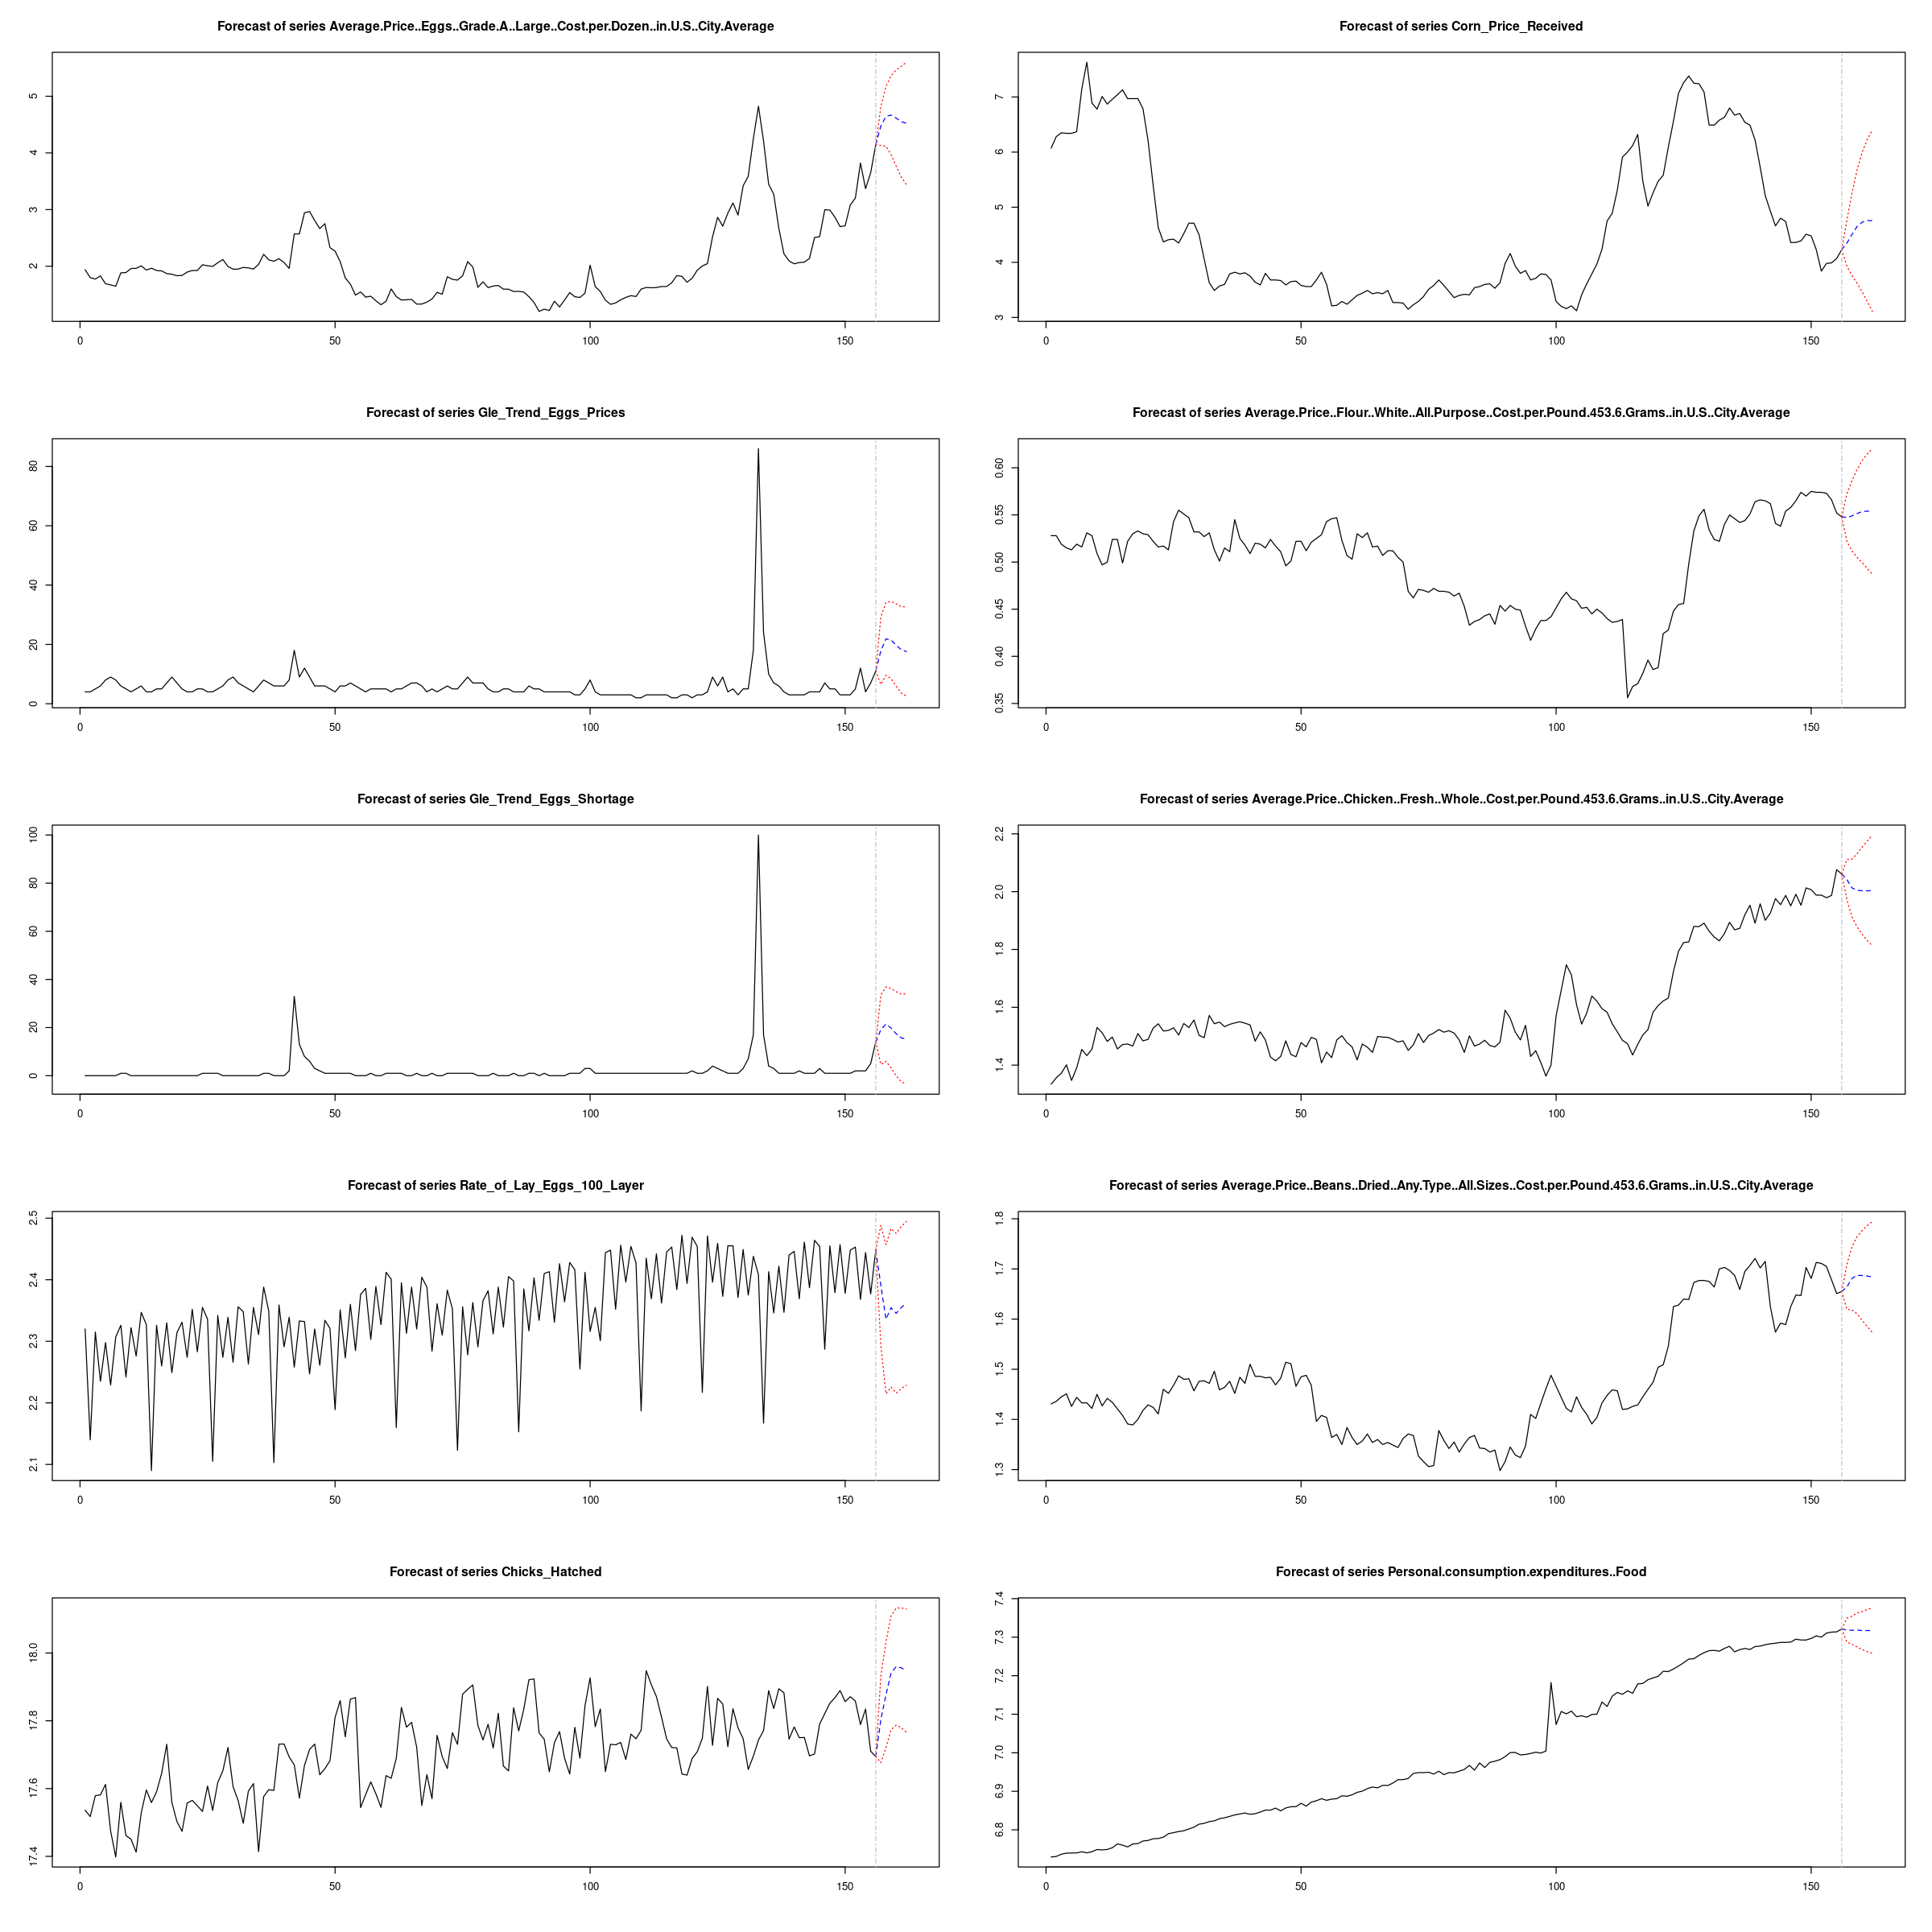

In [49]:
forecast_result <- predict(var_model, n.ahead = 6)  # Forecast next 6 months
options(repr.plot.width = 20, repr.plot.height = 20)
par(bg = "white", mfrow = c(1, 2))
plot(forecast_result)

In [50]:
forecast_result

$Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average
         fcst    lower    upper        CI
[1,] 4.475285 4.132152 4.818419 0.3431335
[2,] 4.644482 4.116414 5.172550 0.5280683
[3,] 4.668034 3.971040 5.365029 0.6969946
[4,] 4.614192 3.765980 5.462404 0.8482123
[5,] 4.551873 3.577057 5.526688 0.9748156
[6,] 4.520946 3.442147 5.599745 1.0787986

$Gle_Trend_Eggs_Prices
         fcst    lower    upper       CI
[1,] 17.88758 6.493929 29.28122 11.39365
[2,] 21.86629 9.581746 34.15084 12.28455
[3,] 21.46773 8.456848 34.47862 13.01089
[4,] 19.76840 5.893487 33.64332 13.87492
[5,] 18.17375 3.613475 32.73402 14.56027
[6,] 17.60015 2.553686 32.64662 15.04647

$Gle_Trend_Eggs_Shortage
         fcst       lower    upper       CI
[1,] 19.13459  4.68727320 33.58190 14.44731
[2,] 21.42876  5.97370676 36.88381 15.45505
[3,] 19.80156  3.33969712 36.26342 16.46186
[4,] 17.41581 -0.05038604 34.88200 17.46619
[5,] 15.70531 -2.51827212 33.92890 18.22359
[6,] 15.23774 -3.53965758 34.0

In [51]:
forecast_dates <- seq(as.Date("2024-12-01") + months(1), by = "month", length.out = 6)

historical_values <- df_matrix[, "Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average"]
forecast_values <- forecast_result$fcst$Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average[, 1]
lower_ci <- forecast_result$fcst$Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average[, 2]
upper_ci <- forecast_result$fcst$Average.Price..Eggs..Grade.A..Large..Cost.per.Dozen..in.U.S..City.Average[, 3]

forecast_values_xts <- xts(forecast_values, order.by = forecast_dates)
lower_ci_xts <- xts(lower_ci, order.by = forecast_dates)
upper_ci_xts <- xts(upper_ci, order.by = forecast_dates)

all_values <- rbind(historical_values, forecast_values_xts)

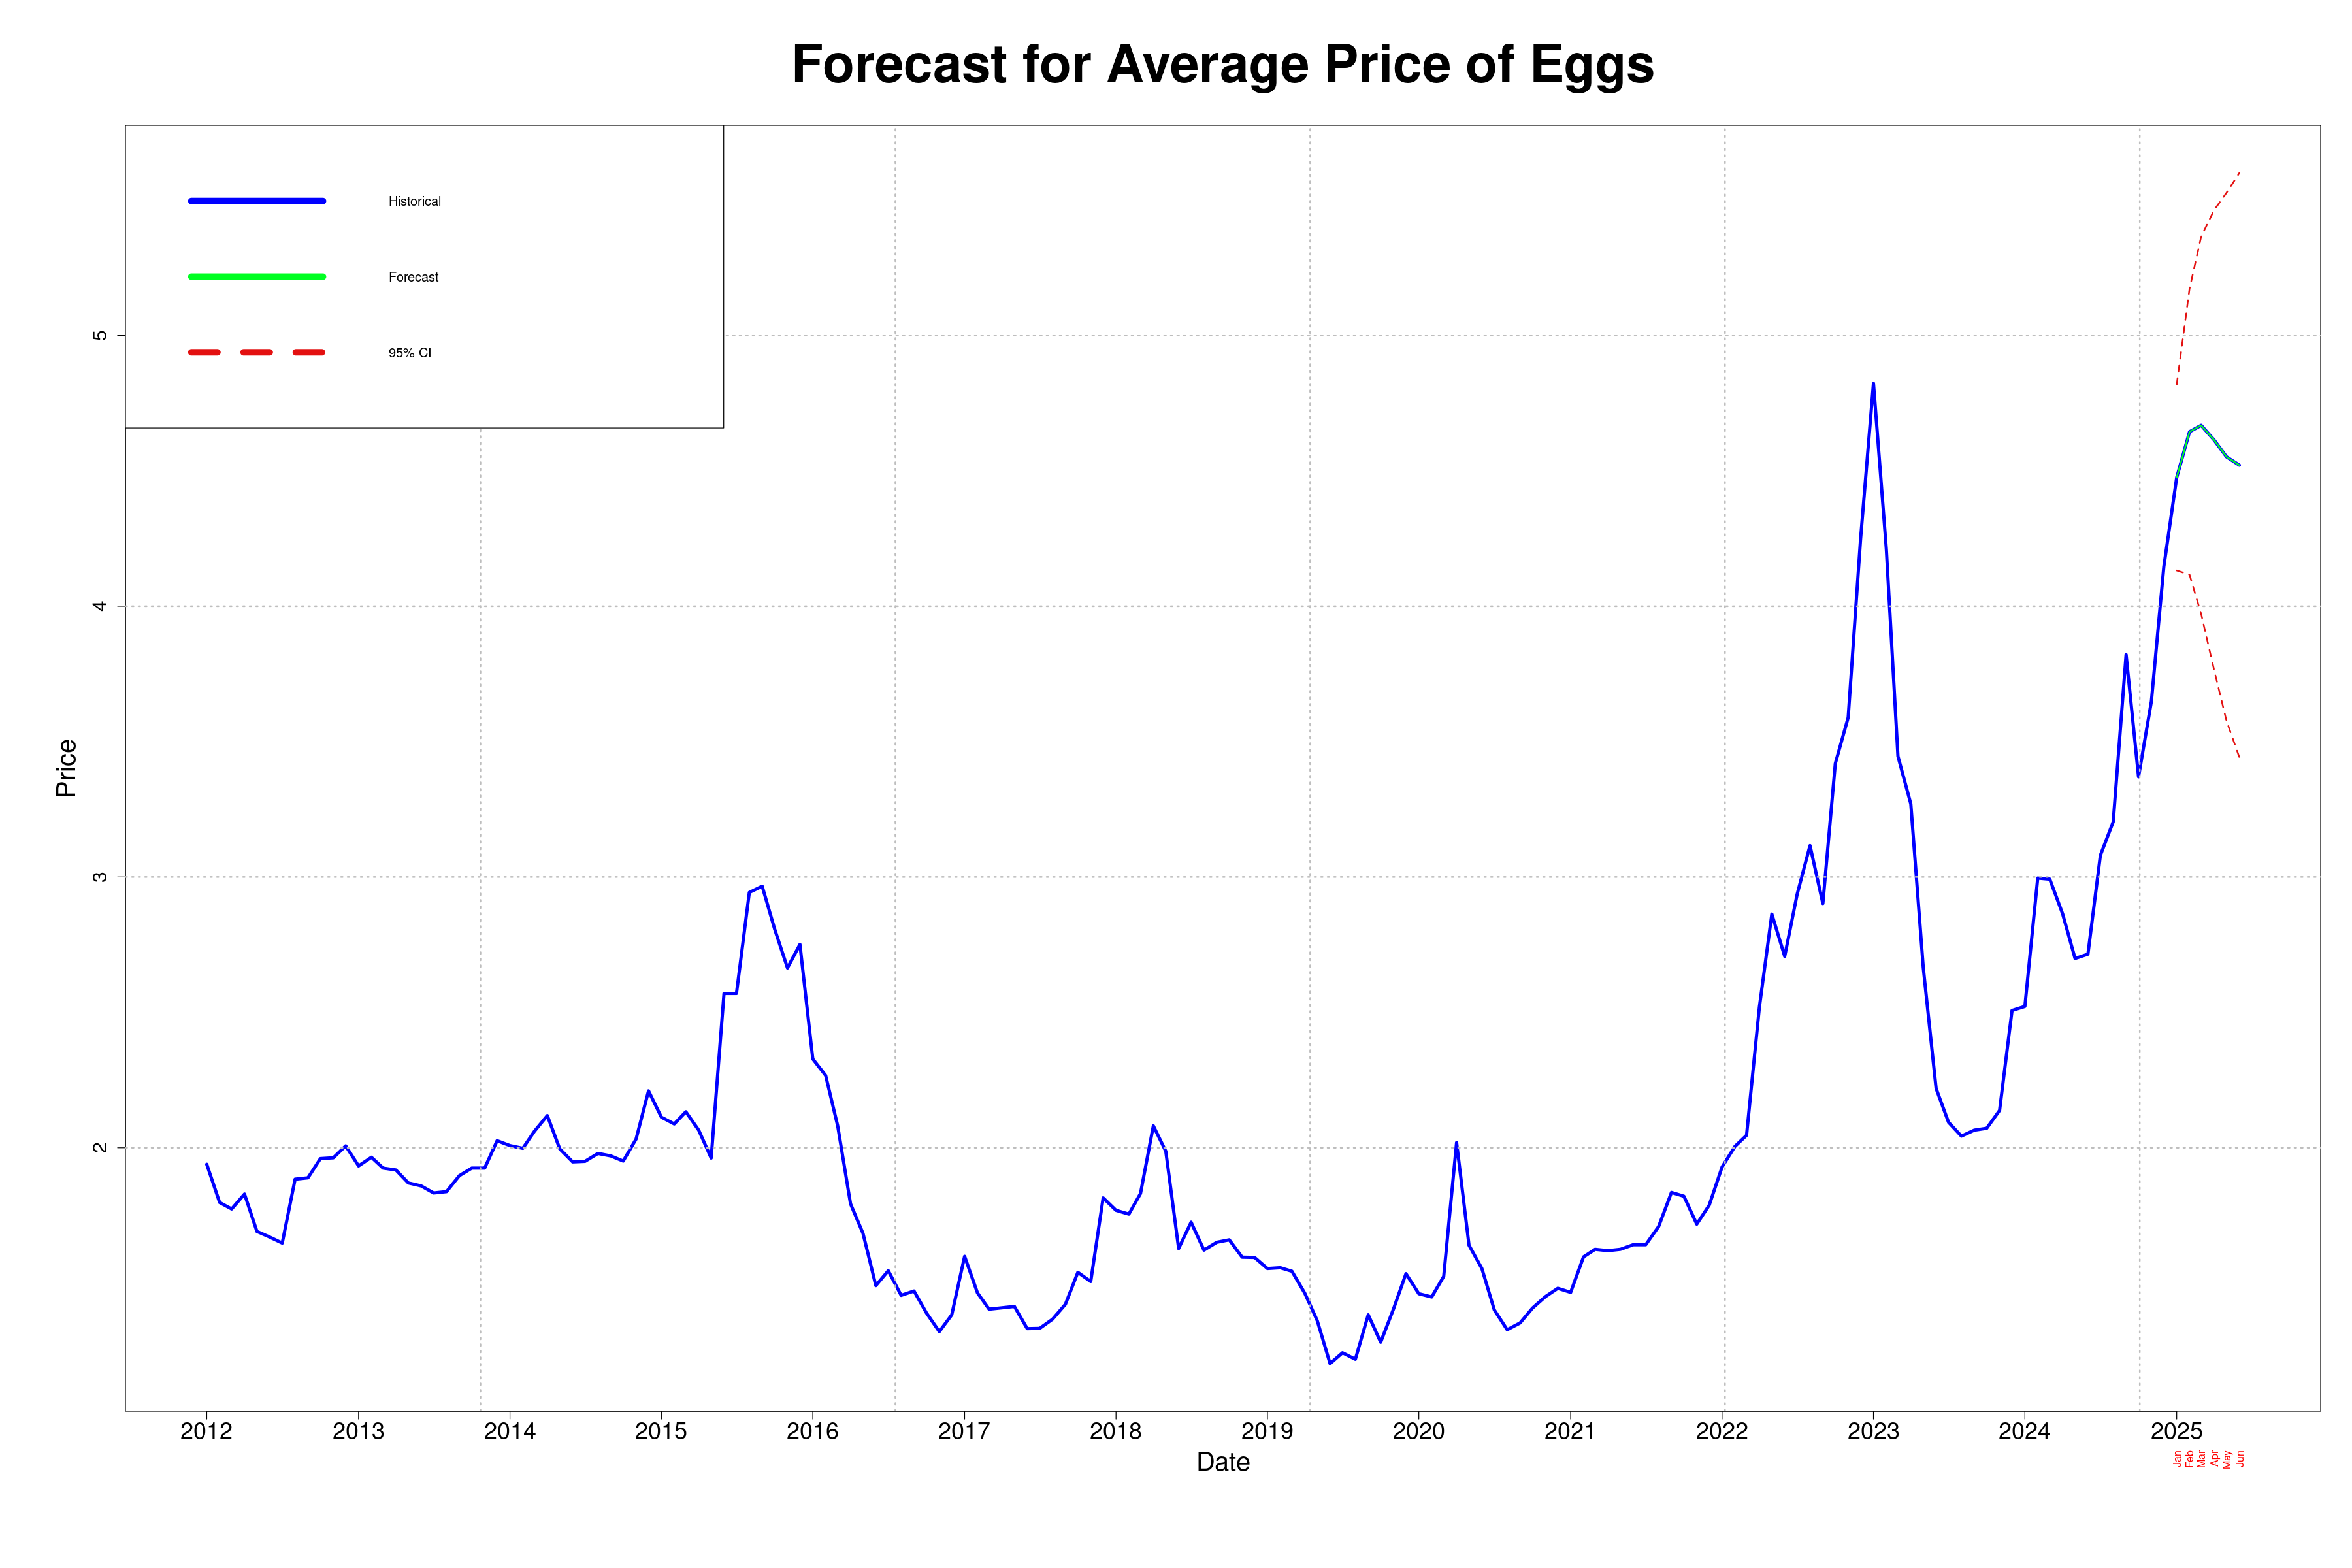

In [52]:
options(repr.plot.width = 30, repr.plot.height = 20)
par(mar = c(10, 8, 8, 2))
par(bg = "white")

plot(index(all_values), c(coredata(historical_values), forecast_values), type = "l", col = "blue", 
     xlab = "Date", ylab = "Price", main = "Forecast for Average Price of Eggs",
     ylim = range(c(coredata(historical_values), lower_ci, upper_ci)), lwd = 4,
     xaxt = "n",
     cex.axis = 1.5,  # Taille des étiquettes des axes (y-axis)
     cex.lab = 2,   # Taille des labels des axes
     cex.main = 4)

grid(nx = NULL, ny = NULL, col = "gray", lty = "dotted", lwd = 2)

axis.Date(1, at = seq(min(index(all_values)), max(index(all_values)), by = "year"), format = "%Y", las = 1, cex.axis = 1.8)

axis(1, at = forecast_dates, labels = format(forecast_dates, "%b"), las = 2, col.axis = "red", cex.axis = 0.8,
     line = 1.5, tick = FALSE)  # Décaler les étiquettes des mois vers le bas

lines(forecast_dates, forecast_values, col = "#00ff22", lwd = 2)
lines(forecast_dates, lower_ci, col = "#e31010", lty = 2, lwd = 2)
lines(forecast_dates, upper_ci, col = "#e31010", lty = 2, lwd = 2)

legend("topleft", legend = c("Historical", "Forecast", "95% CI"), 
       col = c("blue", "#00ff22", "#e31010"), lty = c(1, 1, 2), lwd = 8)

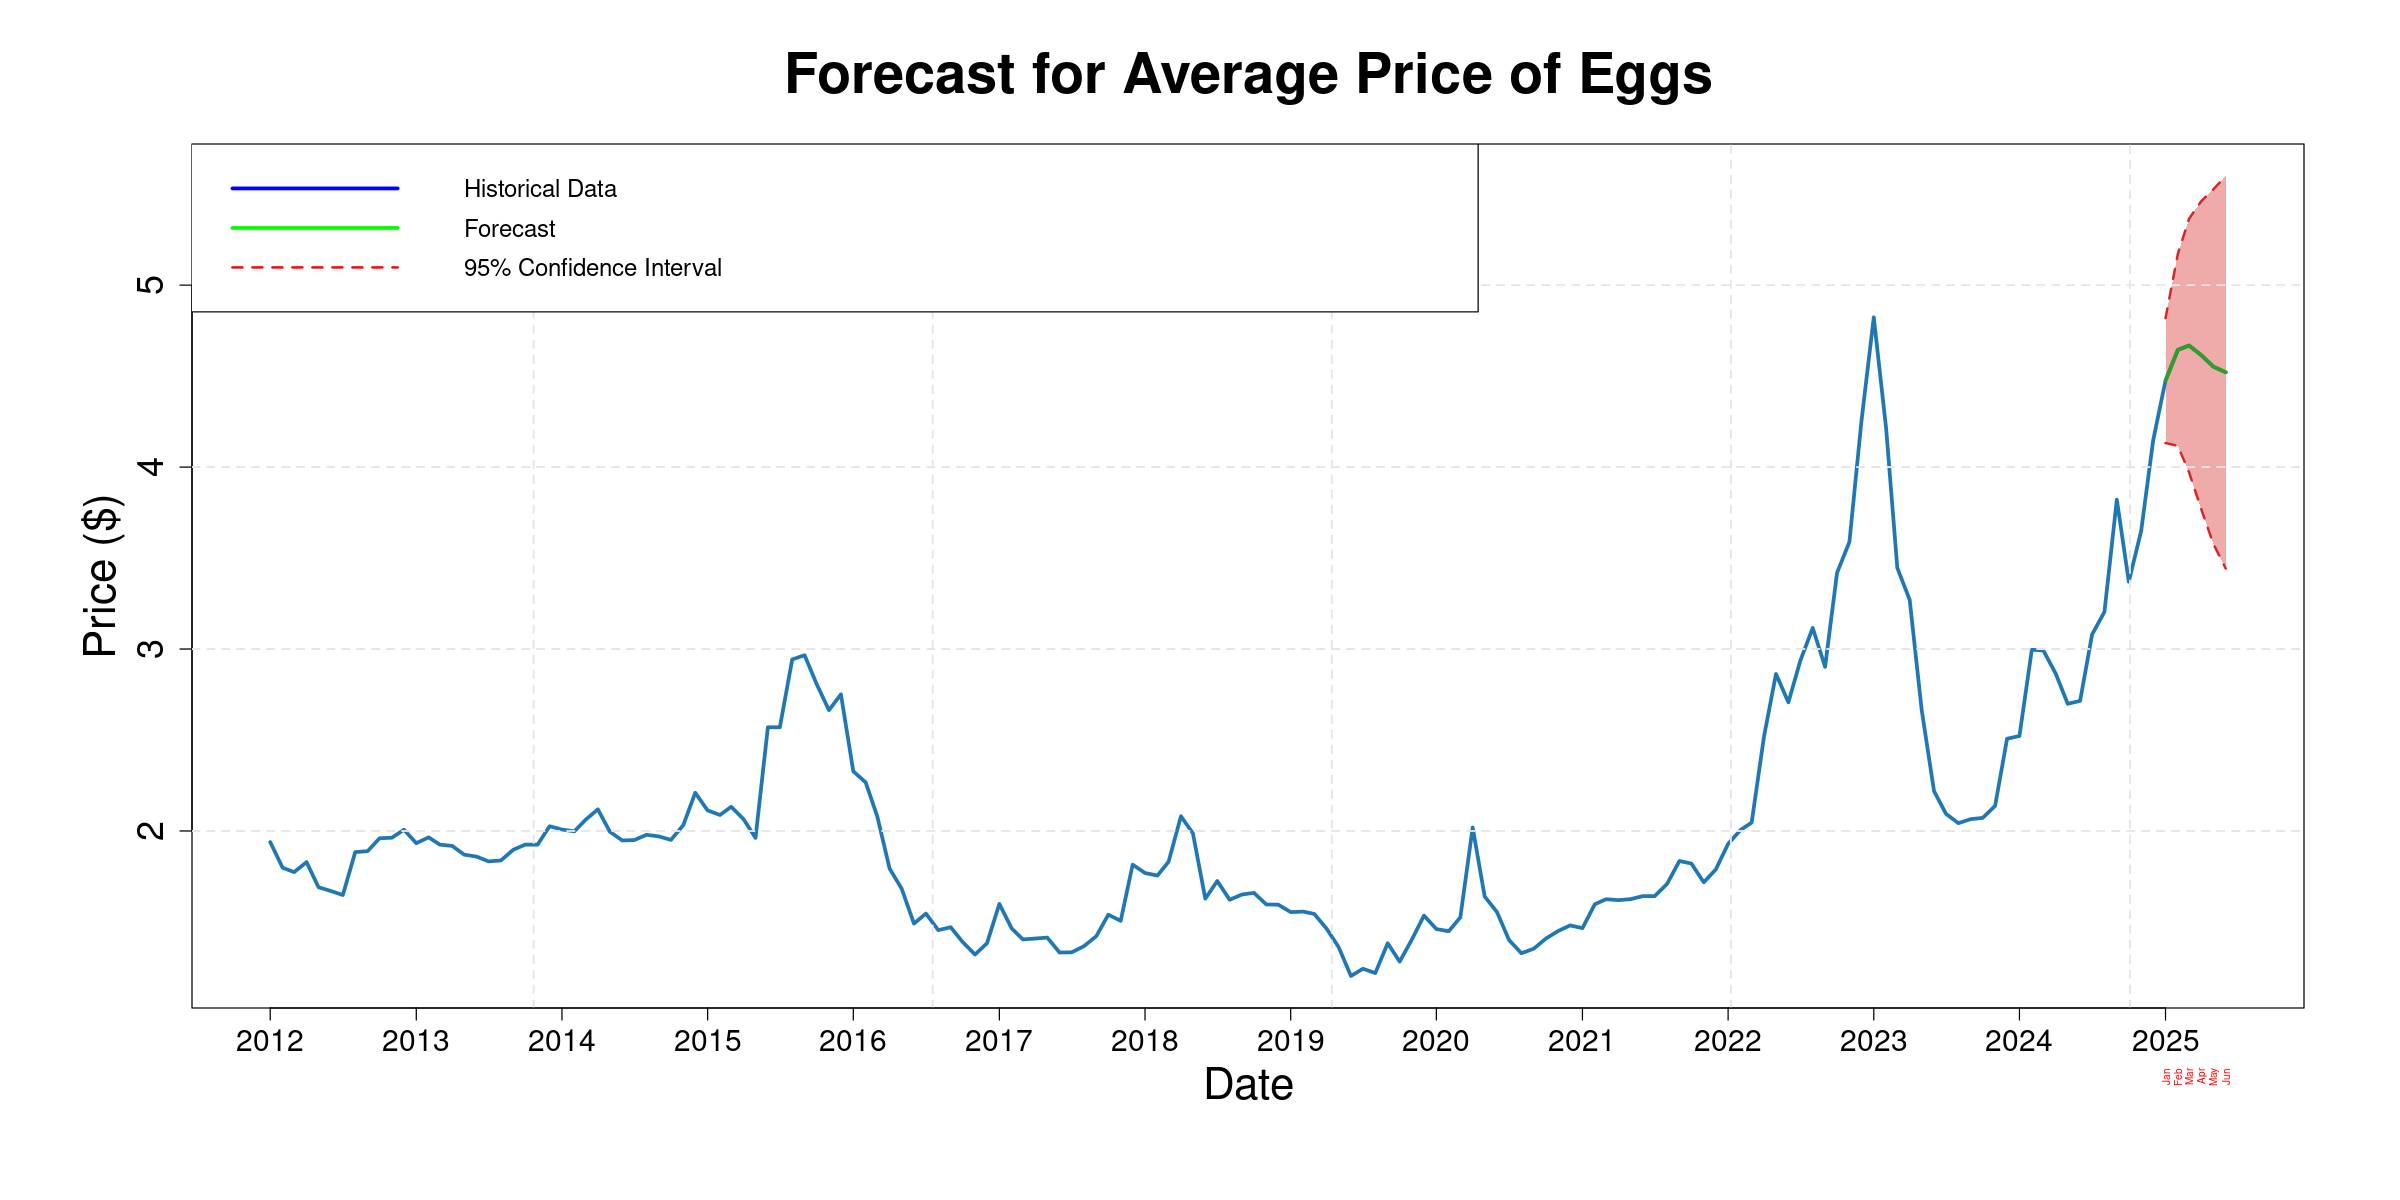

In [53]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mar = c(8, 8, 6, 4))  # Ajustement des marges
par(bg = "white")  # Fond blanc

# Définition des couleurs et styles
col_hist <- "#1f77b4"  # Bleu foncé pour les données historiques
col_forecast <- "#2ca02c"  # Vert pour la prévision
col_ci <- "#d62728"  # Rouge pour l'intervalle de confiance
col_ci_fill <- rgb(214, 39, 40, maxColorValue = 255, alpha = 100)  # Rouge semi-transparent

# Tracé des valeurs historiques et prévisions
plot(index(all_values), c(coredata(historical_values), forecast_values), type = "l", 
     col = col_hist, lwd = 3, xlab = "Date", ylab = "Price ($)", 
     main = "Forecast for Average Price of Eggs",
     ylim = range(c(coredata(historical_values), lower_ci, upper_ci)), 
     xaxt = "n", cex.axis = 1.8, cex.lab = 2.2, cex.main = 2.8)

# Ajout de la zone ombrée pour l'intervalle de confiance
polygon(c(forecast_dates, rev(forecast_dates)), 
        c(lower_ci, rev(upper_ci)), 
        col = col_ci_fill, border = NA)

# Lignes de l'intervalle de confiance
lines(forecast_dates, lower_ci, col = col_ci, lty = 2, lwd = 2)
lines(forecast_dates, upper_ci, col = col_ci, lty = 2, lwd = 2)

# Lignes des prévisions
lines(forecast_dates, forecast_values, col = col_forecast, lwd = 3)

# Ajout d'une grille plus légère pour la lisibilité
grid(nx = NULL, ny = NULL, col = "gray90", lty = "dashed", lwd = 1.5)

# Format des axes
axis.Date(1, at = seq(min(index(all_values)), max(index(all_values)), by = "year"), format = "%Y", las = 1, cex.axis = 1.5)
axis(1, at = forecast_dates, labels = format(forecast_dates, "%b"), las = 2, col.axis = "red", cex.axis = 0.5, 
     line = 1.5, tick = FALSE)

# Ajout d'une légende plus lisible
legend("topleft", 
       legend = c("Historical Data", "Forecast", "95% Confidence Interval"), 
       col = c("blue", "green", "red"), 
       lty = c(1, 1, 2), 
       lwd = c(3, 3, 2), 
       bg = "white", 
       box.lwd = 1,   # Bordure plus fine
       box.col = "black",  # Bordure noire pour visibilité
       cex = 1.2,   # Réduction de la taille du texte
       pt.cex = 1.5,  # Taille des icônes réduite
       x.intersp = 0.8,  # Moins d'espace horizontal
       y.intersp = 0.8,  # Moins d'espace vertical
       inset = c(-0.02, 0)  # Déplacer la légende légèrement vers l'extérieur
)

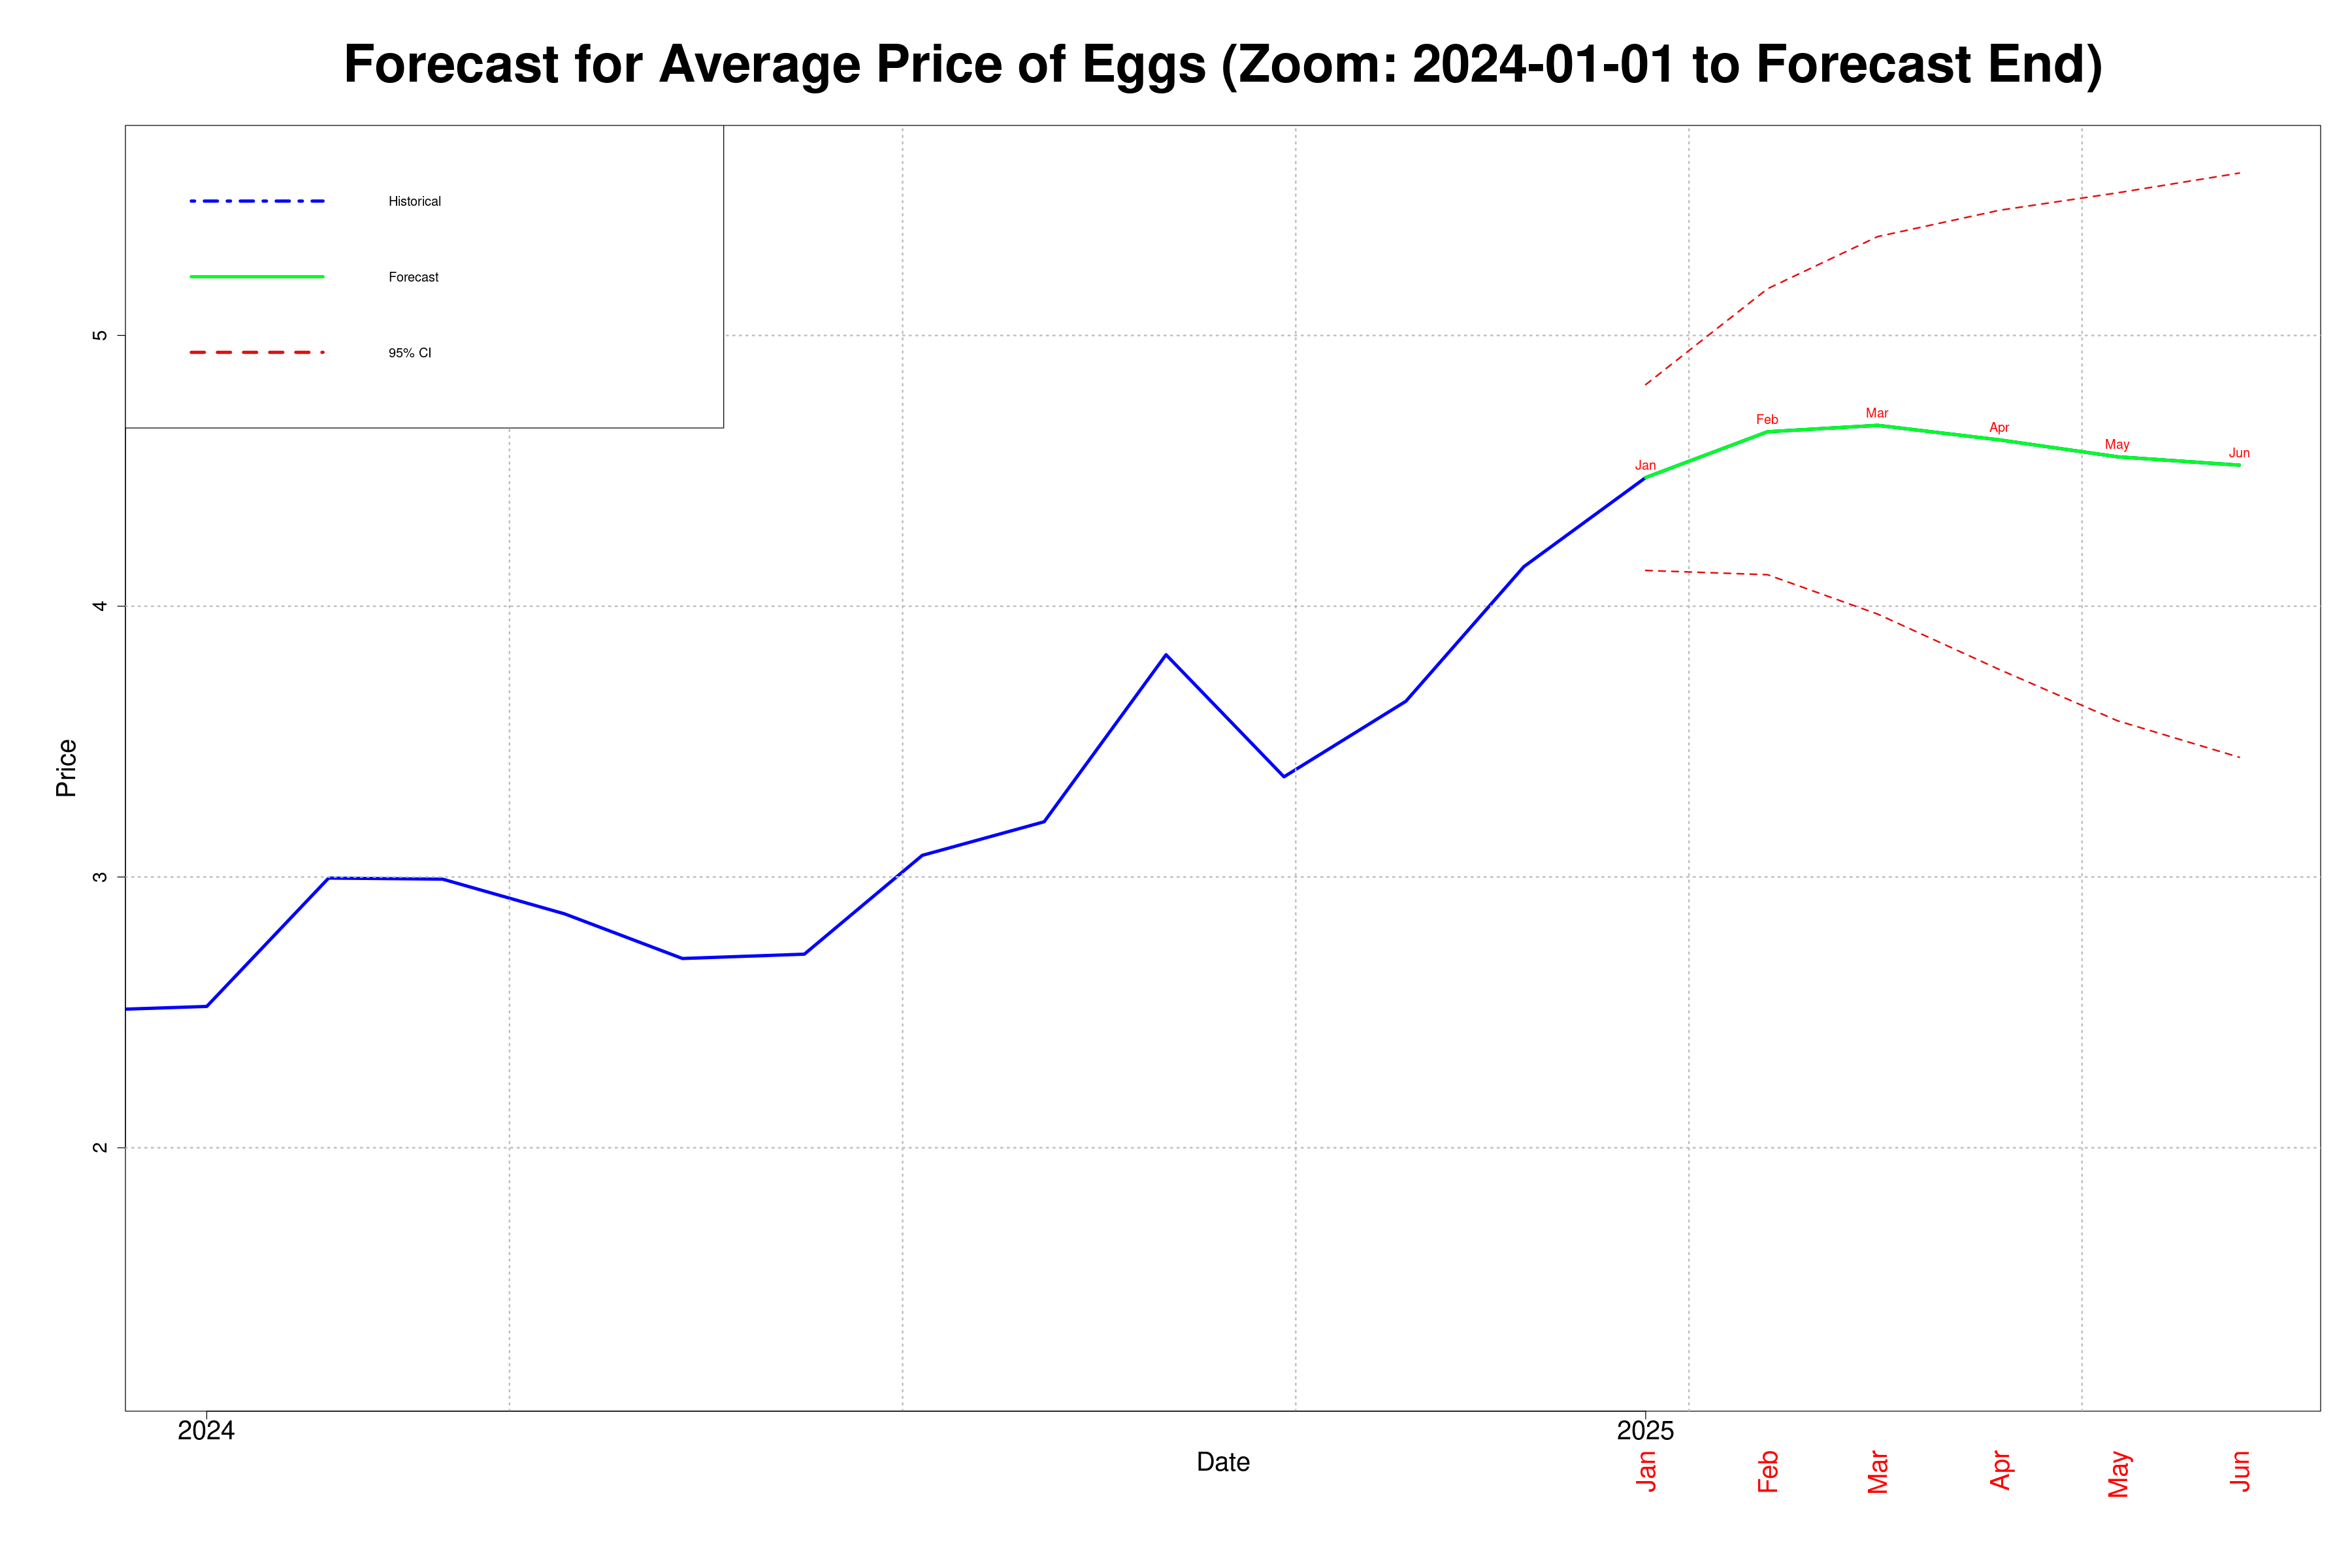

In [54]:
options(repr.plot.width = 30, repr.plot.height = 20)
par(mar = c(10, 8, 8, 2))
par(bg = "white")

# Définir la période de zoom
zoom_start <- as.Date("2024-01-01")
zoom_end <- max(forecast_dates)  # Dernière date de prédiction

# Tracer le graphique avec zoom
plot(index(all_values), c(coredata(historical_values), forecast_values), type = "l", col = "blue", 
     xlab = "Date", ylab = "Price", main = "Forecast for Average Price of Eggs (Zoom: 2024-01-01 to Forecast End)",
     ylim = range(c(coredata(historical_values), lower_ci, upper_ci)), lwd = 4,
     xaxt = "n", xlim = c(zoom_start, zoom_end),
     cex.axis = 1.5,  # Taille des étiquettes des axes (y-axis)
     cex.lab = 2,   # Taille des labels des axes
     cex.main = 4)    # Taille du titre

# Ajouter une grille
grid(nx = NULL, ny = NULL, col = "gray", lty = "dotted", lwd = 2)

# Ajouter l'axe des x avec uniquement les années (agrandir les années)
axis.Date(1, at = seq(zoom_start, zoom_end, by = "year"), format = "%Y", las = 1, cex.axis = 2)

# Ajouter les mois uniquement pour les points de prévision sur une deuxième ligne (agrandir les mois)
axis(1, at = forecast_dates, labels = format(forecast_dates, "%b"), las = 2, col.axis = "red",
     line = 1.5, tick = FALSE, cex.axis = 2)  # Décaler les étiquettes des mois vers le bas

# Ajouter les prévisions et les intervalles de confiance
lines(forecast_dates, forecast_values, col = "#00ff22", lwd = 4)
lines(forecast_dates, lower_ci, col = "#e31010", lty = 2, lwd = 2)
lines(forecast_dates, upper_ci, col = "#e31010", lty = 2, lwd = 2)

text(forecast_dates, forecast_values, labels = format(forecast_dates, "%b"), pos = 3, col = "red", cex = 1)

# Ajouter une légende
legend("topleft", legend = c("Historical", "Forecast", "95% CI"), 
       col = c("blue", "#00ff22", "#e31010"), lty = c(4, 1, 2), lwd = 4, cex = 1)

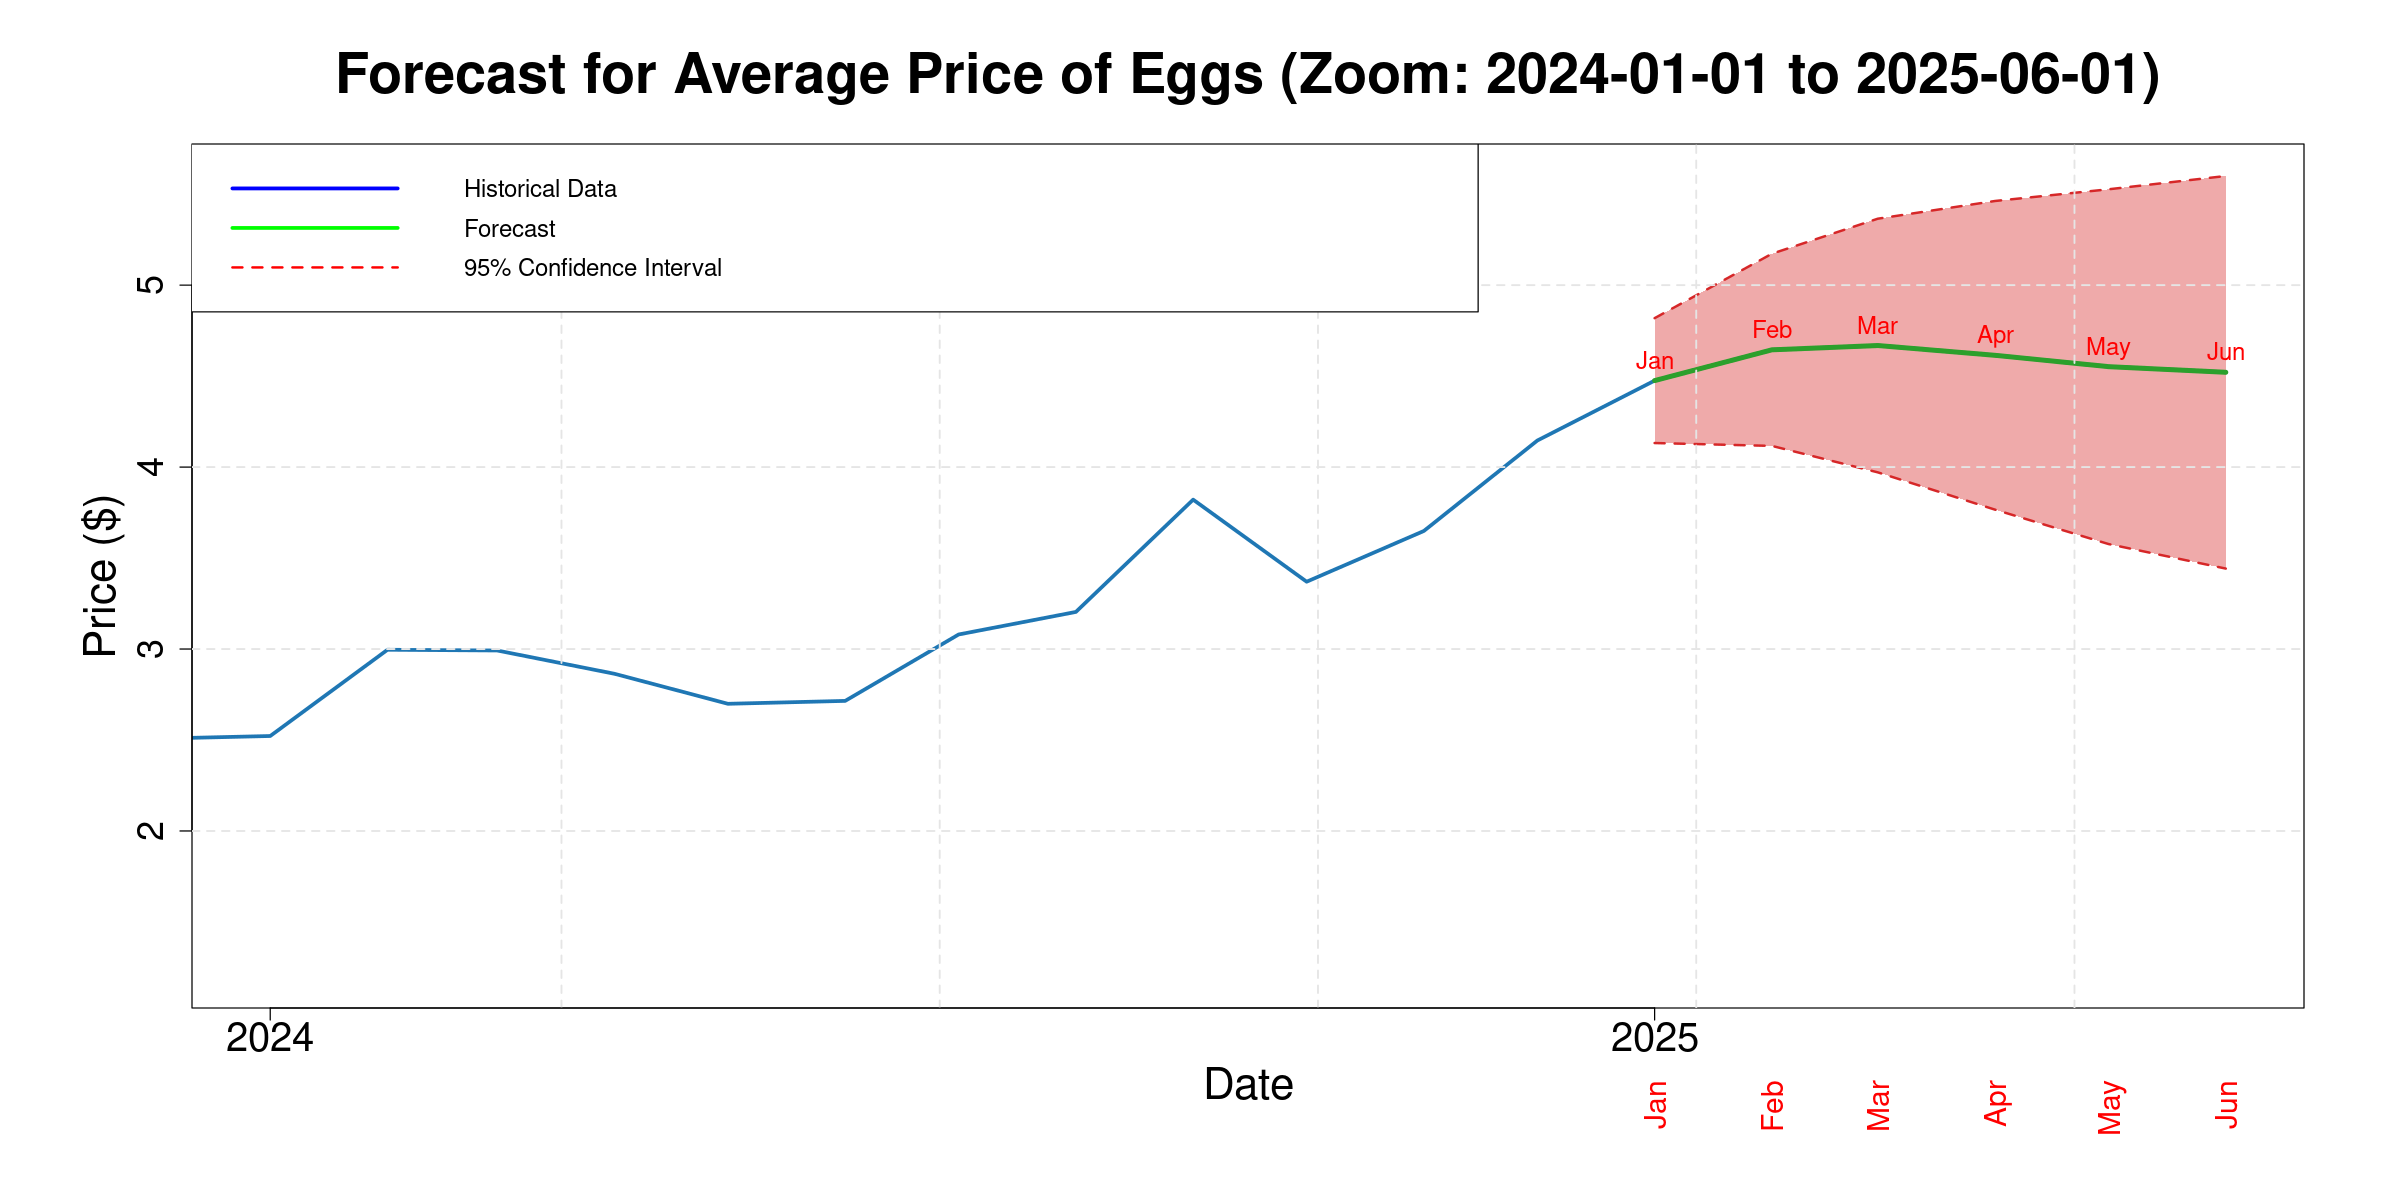

In [55]:
options(repr.plot.width = 20, repr.plot.height = 10)  # Taille optimisée du graphique
par(mar = c(8, 8, 6, 4))  # Marges ajustées
par(bg = "white")  # Fond blanc

# Définir la période de zoom
zoom_start <- as.Date("2024-01-01")
zoom_end <- max(forecast_dates)  # Dernière date de prédiction

# Définition des couleurs et styles
col_hist <- "#1f77b4"  # Bleu pour l'historique
col_forecast <- "#2ca02c"  # Vert pour la prévision
col_ci <- "#d62728"  # Rouge pour l'intervalle de confiance
col_ci_fill <- rgb(214, 39, 40, maxColorValue = 255, alpha = 100)  # Rouge semi-transparent

# Tracer le graphique avec zoom
plot(index(all_values), c(coredata(historical_values), forecast_values), type = "l", 
     col = col_hist, lwd = 3, xlab = "Date", ylab = "Price ($)", 
     main = "Forecast for Average Price of Eggs (Zoom: 2024-01-01 to 2025-06-01)",
     ylim = range(c(coredata(historical_values), lower_ci, upper_ci)), 
     xaxt = "n", xlim = c(zoom_start, zoom_end),
     cex.axis = 1.8, cex.lab = 2.2, cex.main = 2.8)

# Ajout de la zone ombrée pour l'intervalle de confiance
polygon(c(forecast_dates, rev(forecast_dates)), 
        c(lower_ci, rev(upper_ci)), 
        col = col_ci_fill, border = NA)

# Lignes de l'intervalle de confiance
lines(forecast_dates, lower_ci, col = col_ci, lty = 2, lwd = 2)
lines(forecast_dates, upper_ci, col = col_ci, lty = 2, lwd = 2)

# Lignes des prévisions
lines(forecast_dates, forecast_values, col = col_forecast, lwd = 4)

# Ajout d'une grille plus discrète
grid(nx = NULL, ny = NULL, col = "gray90", lty = "dashed", lwd = 1.5)

# Axe des années (agrandi)
axis.Date(1, at = seq(zoom_start, zoom_end, by = "year"), format = "%Y", las = 1, cex.axis = 2)

# Axe des mois pour les prévisions (en rouge et légèrement décalé)
axis(1, at = forecast_dates, labels = format(forecast_dates, "%b"), 
     las = 2, col.axis = "red", 
     cex.axis = 1.5, line = 2, tick = FALSE)  # Mois en plus grand et en rouge

# Annotation des mois sur les points prévus
text(forecast_dates, forecast_values, labels = format(forecast_dates, "%b"), 
     pos = 3, col = "red", cex = 1.2)

# Ajout d'une légende plus lisible
legend("topleft", 
       legend = c("Historical Data", "Forecast", "95% Confidence Interval"), 
       col = c("blue", "green", "red"), 
       lty = c(1, 1, 2), 
       lwd = c(3, 3, 2), 
       bg = "white", 
       box.lwd = 1,   # Bordure plus fine
       box.col = "black",  # Bordure noire pour visibilité
       cex = 1.2,   # Réduction de la taille du texte
       pt.cex = 1.5,  # Taille des icônes réduite
       x.intersp = 0.8,  # Moins d'espace horizontal
       y.intersp = 0.8,  # Moins d'espace vertical
       inset = c(-0.02, 0))  # Déplacer la légende légèrement vers l'extérieur